### This script estimates pv production of a residential location based on its solar panel detection results.

In [49]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from PIL import Image

Implementation:  
- for one address
- get detection mask for solar panel instances
- 
- load building mask
- optionally process building mask to extract the main address
- 
- combine detection mask and main address mask
- 
- overlay combined mask on monthly flux, need to specify month, need to handel potential mismatching resolutions of flux map, building mask, and rgb img. Upsample to maximum resolution
- calculate summed monthly flux
- calculate solar panel area in m^2


In [79]:
def find_main_mask(mask_path):
    """
    Finds the contour closest to the center of the image from a binary mask and returns a mask with only that contour.

    Args:
    mask_path (str): Path to the binary mask GeoTIFF file.

    Returns:
    np.ndarray: A mask with the closest contour to the center of the image filled, value 0/1.
    """
    with rasterio.open(mask_path) as src:
        mask = src.read(1)
        mask_bin = np.uint8(mask * 255)

    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_center = np.array([src.width / 2, src.height / 2])
    min_dist = np.inf
    closest_contour = None

    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroid = np.array([cx, cy])
            dist = np.linalg.norm(centroid - image_center)
            if dist < min_dist:
                min_dist = dist
                closest_contour = contour

    # Create a blank mask and draw the closest contour filled
    closest_contour_mask = np.zeros_like(mask)
    cv2.drawContours(closest_contour_mask, [closest_contour], -1, (1), thickness=cv2.FILLED)
    
    return closest_contour_mask

def get_monthlyFlux(filepath, month):
    # returns the flux map of the given month
    if month < 1 or month > 12:
        raise ValueError("Invalid month. Please choose a value between 1 and 12.")
    try:
        with rasterio.open(filepath) as src:
            if src.count != 12:
                raise ValueError("The GeoTIFF file does not contain 12 bands, as required for monthly data.")

            # Read the band corresponding to the specified month
            data = src.read(month)  # Month 1 corresponds to band 1, and so on
            return data

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

def generate_detMask(image_path, annotation_path, save_path=None):
    """
    Generates and optionally saves a mask from polygon annotations with normalized coordinates.
    Displays the mask using matplotlib.

    Args:
    image_path (str): Path to the image for which the mask is to be created.
    annotation_path (str): Path to the text file containing normalized polygon coordinates.
    save_path (str, optional): Path to save the generated mask image. If None, the mask is not saved.

    Raises:
    FileNotFoundError: If the image or annotation file cannot be found.
    Exception: For any other errors during the execution.
    """
    try:
        # Load the image to find out the dimensions using rasterio
        with rasterio.open(image_path) as src:
            width, height = src.width, src.height
        
        # Prepare a blank mask
        mask = np.zeros((height, width), dtype=np.uint8)

        # Read the annotations and draw each polygon on the mask
        with open(annotation_path, 'r') as file:
            for line in file:
                # line format: class_id x1 y1 x2 y2 ...
                coords = list(map(float, line.split()))[1:]
                if len(coords) % 2 != 0:
                    raise ValueError("Coordinate pairs are incomplete in the annotations file.")
                
                points = np.array([(int(coords[i] * width), int(coords[i + 1] * height)) 
                                   for i in range(0, len(coords), 2)], dtype=np.int32)
                cv2.fillPoly(mask, [points], 255)  # 255 to fill the mask in white

        # Display the mask using matplotlib
        # plt.imshow(mask, cmap='gray')
        # plt.title('Generated Mask')
        # plt.axis('on')
        # plt.show()

        # Save the mask if a save path is provided
        if save_path:
            cv2.imwrite(save_path, mask)
            print(f"Mask saved to {save_path}")
        
        return mask

    except FileNotFoundError as e:
        print(f"File not found: {e}")
        raise
    except Exception as e:
        print(f"An error occurred while generating detection mask: {e}")
        raise

def count_area(mask, res=0.25):
    """
    Calculates the area represented by True (1) pixels in a binary mask, based on the resolution of the mask.

    Args:
    mask (ndarray): Numpy array containing values 0 and 1, where 1 or True indicates the presence of the area to be measured.
    res (float): Resolution of the mask in meters per pixel.

    Returns:
    float: The total area in square meters represented by the True (1) pixels in the mask.

    Raises:
    ValueError: If the input mask does not contain any True (1) values.
    """
    if mask.dtype != bool:
        mask = mask.astype(bool)  # Ensure the mask is boolean for summing True values

    pix_area = np.sum(mask)  # Count of True/1 pixels in the mask

    area = pix_area * res ** 2
    return area

# Example usage:
mask = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
resolution = 0.5  # resolution of 0.5 meters/pixel
total_area = count_area(mask, resolution)
print(f"Total area: {total_area} square meters")
def estimate_monthlyFlux(root, address, ann_path, month):
    # calculates the monthly flux for solar panels on a given address
    # root: str data root path
    # address: str i.e. 1099_Skyevale_NE,_Ada,_MI_49301
    # ann_path: str detection results file path
    monthlyFlux_file = os.path.join(root, address, f"monthlyFlux_{address}.tif")
    buildingMask_file = os.path.join(root, address, f"mask_{address}.tif")
    rgb_file = os.path.join(root,  address, f"rgb_{address}.tif")  # NOTE: rgb_file path structure needs to update
    with rasterio.open(rgb_file) as img:
        img_shape = img.shape
    # get mask for main building
    main_buildingMask = find_main_mask(buildingMask_file)
    buildingMask_res = main_buildingMask.shape
    monthFlux = get_monthlyFlux(monthlyFlux_file, month)
    fluxMap_shape = monthFlux.shape    # the shape of monthFlux is different from image shape
    scale = min()
    dets_mask = generate_detMask(image_path, ann_path)

    # TODO: need to handel potential mismatching resolutions of flux map, building mask, and rgb img
    #       upsample to maximum resolution
    

img_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/jpg_1099_Skyevale_NE,_Ada,_MI_49301.jpg'
det_mask = generate_detMask(img_path, '/home/psc/Desktop/PSC/Custom_Dataset/custom-dataset-2000-seg/valid/labels/1-Toll-Ln_18_quad_1_png.rf.41bc7cf400d0177429efd261cfb65b2c.txt')
print(count_area(det_mask))

Total area: 0.75 square meters
66.3125


/home/psc/miniconda3/envs/solarRec/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


/home/psc/miniconda3/envs/solarRec/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(560, 558)
(560, 558, 3)


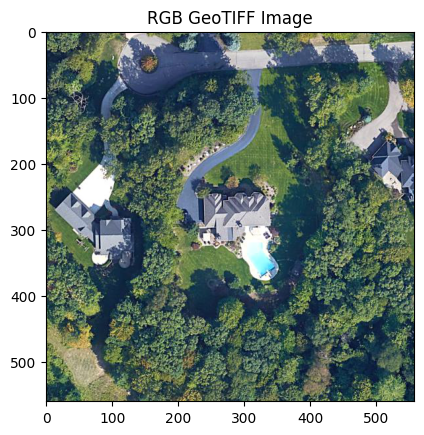

In [46]:
def visualize_geotiff_rgb(filepath):
    """
    Visualize a GeoTIFF file as an RGB image, assuming the file has no extension but contains at least three bands.
    
    Args:
    filepath (str): Path to the GeoTIFF file without the extension.
    
    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the file does not contain at least three bands.
    """
    try:
        with rasterio.open(filepath) as src:
            # Check if there are at least three bands
            if src.count < 3:
                raise ValueError("GeoTIFF file does not contain enough bands for RGB visualization (requires at least 3 bands).")
            print(src.shape)
            # Read the first three bands (Red, Green, Blue)
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)
            
            # Stack bands
            rgb = np.dstack((red, green, blue))
            
    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    # Normalize the bands to (0, 1) for plotting
    rgb_normalized = rgb.astype('float32')
    max_val = np.percentile(rgb, 99)
    rgb_normalized /= max_val

    # Clip values to the range [0, 1]
    rgb_normalized = np.clip(rgb_normalized, 0, 1)
    print(rgb_normalized.shape)

    # Plotting the data
    plt.imshow(rgb_normalized)
    plt.title('RGB GeoTIFF Image')
    plt.axis('on')  # Hide axes
    plt.show()

# Example usage
img_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/jpg_1099_Skyevale_NE,_Ada,_MI_49301.jpg'
visualize_geotiff_rgb(img_path)

(560, 558)


/home/psc/miniconda3/envs/solarRec/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


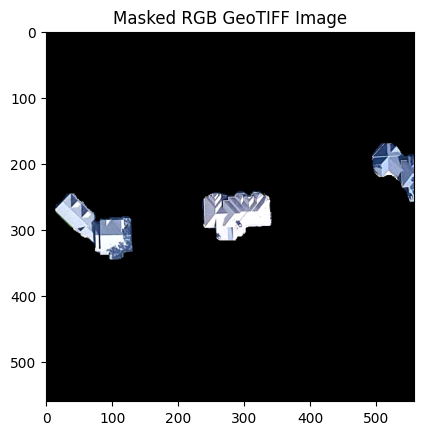

In [64]:
def visualize_geotiff_maskedRGB(filepath, maskpath):
    """
    Visualize a masked RGB GeoTIFF image where the mask highlights certain areas (e.g., rooftops).

    Args:
    filepath (str): Path to the RGB GeoTIFF file.
    maskpath (str): Path to the binary mask GeoTIFF file.

    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the RGB file does not contain at least three bands.
    """
    try:
        with rasterio.open(filepath) as src, rasterio.open(maskpath) as mask_src:
            # Check if there are at least three bands
            if src.count < 3:
                raise ValueError("GeoTIFF file does not contain enough bands for RGB visualization (requires at least 3 bands).")

            # Read the first three bands (Red, Green, Blue)
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)
            
            # Read mask
            mask = mask_src.read(1)

            # TODO: handle case where mask resolution is different from image resolution
            # i.e. scale = min(src.shape[0] / mask.shape[0], src.shape[1] / mask.shape[1])
            print(src.shape)

            # Apply the mask to each RGB band
            red_masked = np.where(mask == 1, red, 0)
            green_masked = np.where(mask == 1, green, 0)
            blue_masked = np.where(mask == 1, blue, 0)

            # Stack masked bands
            rgb_masked = np.dstack((red_masked, green_masked, blue_masked))

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    # Normalize the bands to (0, 1) for plotting
    rgb_normalized = rgb_masked.astype('float32')
    max_val = np.percentile(rgb_masked, 99)
    rgb_normalized /= max_val

    # Clip values to the range [0, 1]
    rgb_normalized = np.clip(rgb_normalized, 0, 1)

    # Plotting the data
    plt.imshow(rgb_normalized)
    plt.title('Masked RGB GeoTIFF Image')
    plt.axis('on')  # Hide axes
    plt.show()
# Example usage
img_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/jpg_1099_Skyevale_NE,_Ada,_MI_49301.jpg'
mask_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/mask_1099_Skyevale_NE,_Ada,_MI_49301.tif'
visualize_geotiff_maskedRGB(img_path, mask_path)

[306478   6002]


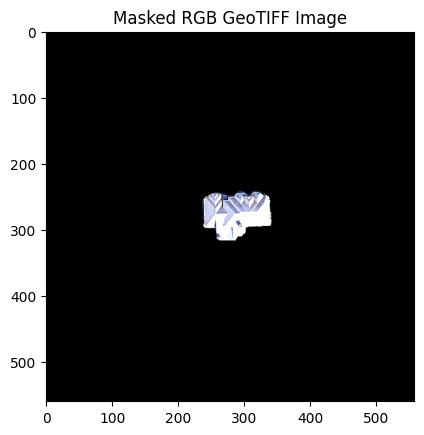

In [72]:
def visualize_geotiff_maskedRGB_2(filepath, mask):
    """
    Visualize a masked RGB GeoTIFF image where the mask highlights certain areas (e.g., rooftops).

    Args:
    filepath (str): Path to the RGB GeoTIFF file.
    maskpath (str): Path to the binary mask GeoTIFF file.

    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the RGB file does not contain at least three bands.
    """
    try:
        with rasterio.open(filepath) as src:
            # Check if there are at least three bands
            if src.count < 3:
                raise ValueError("GeoTIFF file does not contain enough bands for RGB visualization (requires at least 3 bands).")

            # Read the first three bands (Red, Green, Blue)
            red = src.read(1)
            green = src.read(2)
            blue = src.read(3)
            
            # Read mask

            # Apply the mask to each RGB band
            red_masked = np.where(mask == 1, red, 0)
            green_masked = np.where(mask == 1, green, 0)
            blue_masked = np.where(mask == 1, blue, 0)

            # Stack masked bands
            rgb_masked = np.dstack((red_masked, green_masked, blue_masked))

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

    # Normalize the bands to (0, 1) for plotting
    rgb_normalized = rgb_masked.astype('float32')
    max_val = np.percentile(rgb_masked, 99)
    rgb_normalized /= max_val

    # Clip values to the range [0, 1]
    rgb_normalized = np.clip(rgb_normalized, 0, 1)

    # Plotting the data
    plt.imshow(rgb_normalized)
    plt.title('Masked RGB GeoTIFF Image')
    plt.axis('on')
    plt.show()

mask_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/mask_1099_Skyevale_NE,_Ada,_MI_49301.tif'
processed_mask = find_main_mask(mask_path)
# print(np.unique(processed_mask, return_counts=True))
visualize_geotiff_maskedRGB_2(img_path, processed_mask)


(280, 280)


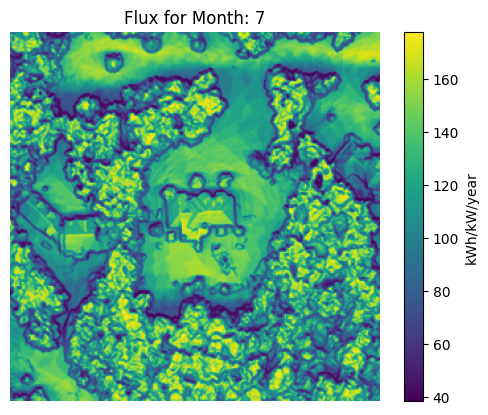

In [37]:
import rasterio
import matplotlib.pyplot as plt

def visualize_monthly_flux(filepath, month):
    """
    Visualize a specific month's flux from a GeoTIFF file with 12 bands, each representing a different month.

    Args:
    filepath (str): Path to the GeoTIFF file.
    month (int): Month to visualize (1 for January, 2 for February, ..., 12 for December).

    Raises:
    FileNotFoundError: If the file cannot be found or read.
    ValueError: If the specified month is not valid or the file does not contain 12 bands.
    """
    if month < 1 or month > 12:
        raise ValueError("Invalid month. Please choose a value between 1 and 12.")
    
    try:
        with rasterio.open(filepath) as src:
            if src.count != 12:
                raise ValueError("The GeoTIFF file does not contain 12 bands, as required for monthly data.")

            # Read the band corresponding to the specified month
            data = src.read(month)  # Month 1 corresponds to band 1, and so on
            print(data.shape)
            # Normalize the data for better visualization
            vmin, vmax = data.min(), data.max()
            plt.imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.colorbar(label='kWh/kW/year')
            plt.title(f'Flux for Month: {month}')
            plt.axis('off')
            plt.show()

    except rasterio.errors.RasterioIOError as e:
        raise FileNotFoundError(f"Unable to locate or read the file at {filepath}") from e

monthlyFlux_path = '/home/psc/Desktop/solarRec/test_data/1099_Skyevale_NE,_Ada,_MI_49301/monthlyFlux_1099_Skyevale_NE,_Ada,_MI_49301.tif'
month = 7
visualize_monthly_flux(monthlyFlux_path, month)